# Classification of fixed size paragraph vectors using LSTM
should be able to deal with all levels using the PARTS_LEVEL param

In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple, defaultdict
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

import seaborn

import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input, Masking
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.convolutional import MaxPooling1D, Convolution1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.recurrent import LSTM

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *

Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


# Global variables used throughout the script

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234
NN_SEED = 1234

In [4]:
NUM_CORES = 16

In [5]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [6]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
VALIDATION_DICT = "validation_dict.pkl"
TEST_MATRIX = "test_matrix.pkl"
TEST_DICT = "test_dict.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"
TYPE_CLASSIFIER= "{}_classifier.pkl"

TRAINING_DATA_MATRIX = "X_level_{}.npy"
TRAINING_LABELS_MATRIX = "y_{}.npy"
VALIDATION_DATA_MATRIX = "Xv_level_{}.npy"
VALIDATION_LABELS_MATRIX = "yv_{}.npy"

In [7]:
NN_PARAMETER_SEARCH_PREFIX = "lstm_{}_level_{}_batch_{}_nn_parameter_searches.pkl"

In [8]:
SAMPLE_RATIO = 0.15

In [9]:
root_location = "/mnt/data2/shalaby/"
big_data_location = "/mnt/data/shalaby/"

doc_vec_types = "extended_abs_desc_claims_large_sample_chunks"
doc_vec_preprocessed_data_types = "extended_pv_abs_desc_claims_large_sample_chunks"

exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(big_data_location, "parameter_search_doc2vec_models_" + doc_vec_types, "full")
nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_" + doc_vec_types)
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

#training_file = root_location + "docs_output.json"
training_file = root_location + 'docs_output.json'

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
# training_docs_list_file = exports_location + "extended_pv_training_docs_list.pkl"
# validation_docs_list_file = exports_location + "extended_pv_validation_docs_list.pkl"
# test_docs_list_file = exports_location + "extended_pv_test_docs_list.pkl"
training_docs_list_file = exports_location + "extended_pv_training_docs_list_" + str(SAMPLE_RATIO) + ".pkl"
validation_docs_list_file = exports_location + "extended_pv_validation_docs_list_" + str(SAMPLE_RATIO) + ".pkl"
test_docs_list_file = exports_location + "extended_pv_test_docs_list_" + str(SAMPLE_RATIO) + ".pkl"

preprocessed_location = os.path.join(big_data_location, "preprocessed_data", doc_vec_preprocessed_data_types) + "/"

training_preprocessed_files_prefix = preprocessed_location + "extended_pv_training_docs_data_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "extended_pv_validation_docs_data_preprocessed-"
test_preprocessed_files_prefix = preprocessed_location + "extended_pv_test_docs_data_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

# Load general data required for classification

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 15.2 s, sys: 944 ms, total: 16.1 s
Wall time: 16.1 s


In [11]:
len(training_docs_list)

254767

In [12]:
len(validation_docs_list)

60957

In [13]:
len(test_docs_list)

79785

# Utility Functions for data loading

In [14]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector
    
def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [15]:
class FixedDocumentsStatsGenerator(object):
    def __init__(self, filename_prefix):
        self.filename_prefix = filename_prefix
        self.docids = []
        self.doc_parts = defaultdict(list)
        self.doc_part_chunks = defaultdict(list)
        self.curr_doc_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        info("Loading new batch for index: {}".format(self.curr_doc_index))
        true_docs_count = 0
        try:
            with open(self.filename_prefix + str(self.curr_doc_index)) as preproc_file:
                for line in preproc_file:
                    line_array = line.split(" ", 1)
                    entity_id = line_array[0].strip()
                    if self.is_doc(entity_id):
                        self.docids.append(entity_id)
                        true_docs_count+= 1
                    elif self.is_doc_part(entity_id):
                        self.doc_parts[self.get_doc_id(entity_id)].append(entity_id)
                    elif self.is_doc_part_chunk(entity_id):
                        self.doc_part_chunks[self.get_doc_id(entity_id)].append(entity_id)
            self.batch_end = self.curr_doc_index + true_docs_count - 1 
            info("Finished loading new batch of {} documents".format(true_docs_count))
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_doc_index))
            raise StopIteration()
    def get_stats(self):
        try:
            while True:
                if self.curr_doc_index > self.batch_end:
                    self.load_new_batch_in_memory()
                self.curr_doc_index = self.batch_end + 1
        except StopIteration:
            pass
            
    def get_doc_id(self, entity_id):
        return entity_id.split("_")[0]
    def get_entity_parts(self, entity_id):
        return entity_id.split("_")
    def is_doc(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 1:
            return True
        return False
    def is_doc_part(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 2:
            return True
        return False
    def is_doc_part_chunk(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 3:
            return True
        return False

In [16]:
def get_doc_vector(entity_id):
    if entity_id in doc2vec_model.docvecs:
        if DOC2VEC_MMAP:
            normal_array = []
            normal_array[:] = doc2vec_model.docvecs[entity_id][:]
            return normal_array
        else:
            return doc2vec_model.docvecs[entity_id]
    else:
        # some claims have low token count, so they cant fill out the whole 16 spots
        return ZERO_VECTOR

def data_generator(doc_stats, doc_id):
    yield get_doc_vector(doc_id)
    if PARTS_LEVEL >= LEVEL_DIVISIONS:
        for part_id in doc_stats.doc_parts[doc_id]:
            yield get_doc_vector(part_id)
    if PARTS_LEVEL >= LEVEL_CHUNKS:
        for part_id in doc_stats.doc_part_chunks[doc_id]:
            yield get_doc_vector(part_id)
    while True:
        yield ZERO_VECTOR

def validation_data_generator(doc_stats, validation_dict, doc_id):
    yield validation_dict[doc_id]
    if PARTS_LEVEL >= LEVEL_DIVISIONS:
        for part_id in doc_stats.doc_parts[doc_id]:
            yield validation_dict[part_id]
    if PARTS_LEVEL >= LEVEL_CHUNKS:
        for part_id in doc_stats.doc_part_chunks[doc_id]:
            yield validation_dict[part_id]
    while True:
        yield ZERO_VECTOR
        

In [17]:
def get_training_data(doc2vec_model, classifications, classifications_type, doc_stats, sequence_size, embedding_size):
    """
    Creates or loads the X and y matrices used for training
    """
    def get_training_y_labels():
        """
        Creates or loads the y matrix used for training
        """
        if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       TRAINING_LABELS_MATRIX.format(classifications_type))):
            info("Creating Training Labels")
            one_hot_encoder = OneHotEncoder(classifications)
            classifications_set = set(classifications)
            training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
            for i, doc_id in enumerate(training_docs_list):
                eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
                training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        else:    
            training_labels_mat = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                            TRAINING_LABELS_MATRIX.format(classifications_type))))
        return training_labels_mat

    
    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       TRAINING_DATA_MATRIX.format(PARTS_LEVEL))):
        info("Creating Training Data")
        one_hot_encoder = OneHotEncoder(classifications)
        classifications_set = set(classifications)
        # 1st level: document level
        training_data = np.ndarray((len(training_docs_list), sequence_size, embedding_size), dtype=np.float32)
        info("Training Data shape: {}".format(training_data.shape))
        training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
        for i, doc_id in enumerate(training_docs_list):
            data_gen = data_generator(doc_stats, doc_id)
            # 2nd level: constituents
            for j in range(sequence_size):
                #3rd level: feature vectors
                training_data[i][j] = data_gen.next()
            eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
            training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
            if i % 10000 == 0:
                info("Finished {} in training".format(i))
        
        info("Saving Training Data to file...")
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  TRAINING_DATA_MATRIX.format(PARTS_LEVEL)), "w"), training_data)
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  TRAINING_LABELS_MATRIX.format(classifications_type)), "w"), training_labels_mat)
    else:
        info("Loading Training Data from file")
        training_data = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  TRAINING_DATA_MATRIX.format(PARTS_LEVEL))))
        training_labels_mat = get_training_y_labels()
        
    return training_data, training_labels_mat

In [18]:
def get_validation_data(validation_dict, classifications, classifications_type, doc_stats, sequence_size, embedding_size):
    """
    Creates or loads the X and y matrices used for validation
    """
    def get_validation_y_labels():
        """
        Creates or loads the y matrix used for validation
        """
        if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       VALIDATION_LABELS_MATRIX.format(classifications_type))):
            info("Creating Validation Labels")
            one_hot_encoder = OneHotEncoder(classifications)
            classifications_set = set(classifications)
            validation_labels_mat = np.zeros((len(validation_docs_list), len(classifications)), dtype=np.int8)
            for i, doc_id in enumerate(validation_docs_list):
                eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
                validation_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        else:    
            info("Loading Validation Labels")
            validation_labels_mat = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                        VALIDATION_LABELS_MATRIX.format(classifications_type))))
        return validation_labels_mat

    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       VALIDATION_DATA_MATRIX.format(PARTS_LEVEL))):
        info("Creating Validation Data")
        one_hot_encoder = OneHotEncoder(classifications)
        classifications_set = set(classifications)
        # 1st level: document level
        validation_data = np.ndarray((len(validation_docs_list), sequence_size, embedding_size), dtype=np.float32)
        info("Validation Data shape: {}".format(validation_data.shape))
        validation_labels_mat = np.zeros((len(validation_docs_list), len(classifications)), dtype=np.int8)
        for i, doc_id in enumerate(validation_docs_list):
            data_gen = validation_data_generator(doc_stats, validation_dict, doc_id)
            # 2nd level: constituents
            for j in range(sequence_size):
                #3d level: feature vectors
                validation_data[i][j] = data_gen.next()
            eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
            validation_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
            if i % 10000 == 0:
                info("Finished {} in validation".format(i))
        
        info("Saving Validation Data to file...")
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  VALIDATION_DATA_MATRIX.format(PARTS_LEVEL)), "w"), validation_data)
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  VALIDATION_LABELS_MATRIX.format(classifications_type)), "w"), validation_labels_mat)
    else:
        info("Loading Validation Data from file")
        validation_data = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  VALIDATION_DATA_MATRIX.format(PARTS_LEVEL))))
        validation_labels_mat = get_validation_y_labels()
        
    return validation_data, validation_labels_mat

In [19]:
class MetricsCallback(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    def __init__(self):
        MetricsCallback.EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
        MetricsCallback.GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
        MetricsCallback.GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallback.GRAPH_MIN, MetricsCallback.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            #print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict(Xv)
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

In [20]:
def create_keras_rnn_model(input_size, output_size, lstm_output_size, w_dropout_do, u_dropout_do, 
                           stack_layers=1, conv_size=None):
    
    model= Sequential()
#     model.add(Masking(mask_value=0., input_shape=(MAX_SIZE, input_size)))
    if conv_size:
        model.add(Convolution1D(nb_filter=conv_size, input_shape=(MAX_SIZE, input_size), filter_length=3, 
                                border_mode='same', activation='relu'))
        model.add(MaxPooling1D(pool_length=2))
    for i in range(stack_layers):
        model.add(LSTM(lstm_output_size, input_dim=input_size, dropout_W=w_dropout_do, dropout_U=u_dropout_do,
                       return_sequences=False if i+1 == stack_layers else True,
                  name='lstm_{}_w-drop_{}_u-drop_{}_layer_{}'.format(lstm_output_size, str(u_dropout_do), str(w_dropout_do), str(i+1))))
    model.add(Dense(output_size, activation='sigmoid', name='sigmoid_output'))
    model.compile(optimizer=NN_OPTIMIZER, loss='binary_crossentropy')
    return model

# Global Param Loop

In [21]:
# minimum change in val_loss from previous epoch to register as a decrease
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
# how many epochs to wait when there is no decrease in val_loss before early stopping
early_stopper_patience = {
    'sections': 15,
    'classes': 15,
    'subclasses': 15
}
# number of epochs after which we do periodic evaluation of validation metrics
epochs_before_validation = {
    'sections': 10,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.5},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [22]:
LEVEL_DOC = 0
LEVEL_DIVISIONS = 1
LEVEL_CHUNKS = 2

In [23]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 8
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100000 # report vocab progress every x documents

DOC2VEC_MMAP = 'r'
# DOC2VEC_MMAP = None

ZERO_VECTOR = [0] * DOC2VEC_SIZE

In [25]:
GLOBAL_PARMS_TO_RUN = [
#     {
#         'doc2vec_epoch': 3,
#         'classifications': sections,
#         'classifications_type': 'sections',
#         'parts_level': LEVEL_CHUNKS,
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': None
#     }, 
#     {
#         'doc2vec_epoch': 12,
#         'classifications': sections,
#         'classifications_type': 'sections',
#         'parts_level': LEVEL_CHUNKS,
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 1,
#         'lstm_conv_size': None
#     }
#     {
#         'doc2vec_epoch': 8,
#         'classifications': sections,
#         'classifications_type': 'sections',
#         'parts_level': LEVEL_DOC,
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 2,
#         'lstm_conv_size': None
#     },{
#         'doc2vec_epoch': 8,
#         'classifications': sections,
#         'classifications_type': 'sections',
#         'parts_level': LEVEL_DOC,
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 3,
#         'lstm_conv_size': None
#     },
    {
        'doc2vec_epoch': 8,
        'classifications': sections,
        'classifications_type': 'sections',
        'parts_level': LEVEL_DIVISIONS,
        'nn_batch_size': 2048,
        'lstm_output_size': 500,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 2,
        'lstm_conv_size': None
    },{
        'doc2vec_epoch': 8,
        'classifications': sections,
        'classifications_type': 'sections',
        'parts_level': LEVEL_DIVISIONS,
        'nn_batch_size': 2048,
        'lstm_output_size': 500,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 3,
        'lstm_conv_size': None
    },{
        'doc2vec_epoch': 8,
        'classifications': sections,
        'classifications_type': 'sections',
        'parts_level': LEVEL_CHUNKS,
        'nn_batch_size': 2048,
        'lstm_output_size': 500,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 2,
        'lstm_conv_size': None
    },
    {
        'doc2vec_epoch': 8,
        'classifications': sections,
        'classifications_type': 'sections',
        'parts_level': LEVEL_CHUNKS,
        'nn_batch_size': 1024,
        'lstm_output_size': 500,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 3,
        'lstm_conv_size': None
    },
#     {
#         'doc2vec_epoch': 8,
#         'classifications': valid_classes,
#         'classifications_type': 'classes',
#         'parts_level': LEVEL_DOC,
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 2,
#         'lstm_conv_size': None
#     },{
#         'doc2vec_epoch': 8,
#         'classifications': valid_classes,
#         'classifications_type': 'classes',
#         'parts_level': LEVEL_DOC,
#         'nn_batch_size': 2048,
#         'lstm_output_size': 500,
#         'lstm_w_dropout': 0.5,
#         'lstm_u_dropout': 0.5,
#         'lstm_stack_layers': 3,
#         'lstm_conv_size': None
#     },
    {
        'doc2vec_epoch': 8,
        'classifications': valid_classes,
        'classifications_type': 'classes',
        'parts_level': LEVEL_DIVISIONS,
        'nn_batch_size': 2048,
        'lstm_output_size': 500,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 2,
        'lstm_conv_size': None
    },{
        'doc2vec_epoch': 8,
        'classifications': valid_classes,
        'classifications_type': 'classes',
        'parts_level': LEVEL_DIVISIONS,
        'nn_batch_size': 2048,
        'lstm_output_size': 500,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 3,
        'lstm_conv_size': None
    },
    {
        'doc2vec_epoch': 8,
        'classifications': valid_classes,
        'classifications_type': 'classes',
        'parts_level': LEVEL_CHUNKS,
        'nn_batch_size': 2048,
        'lstm_output_size': 500,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 2,
        'lstm_conv_size': None
    },
    {
        'doc2vec_epoch': 8,
        'classifications': valid_classes,
        'classifications_type': 'classes',
        'parts_level': LEVEL_CHUNKS,
        'nn_batch_size': 1024,
        'lstm_output_size': 500,
        'lstm_w_dropout': 0.5,
        'lstm_u_dropout': 0.5,
        'lstm_stack_layers': 3,
        'lstm_conv_size': None
    }
]


==================================== NEW PARAM SET ============================================
{'lstm_stack_layers': 2, 'nn_batch_size': 2048, 'classifications_type': 'sections', 'lstm_w_dropout': 0.5, 'lstm_u_dropout': 0.5, 'parts_level': 1, 'lstm_output_size': 500, 'doc2vec_epoch': 8, 'lstm_conv_size': None}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-03-29 04:08:07,727 : INFO : Loading Training Document Stats
2017-03-29 04:08:26,796 : INFO : Loading Training Data from file


Max Size: 4


2017-03-29 04:08:33,339 : INFO : Loading Validation Document Stats


(254767, 4, 200)
(254767, 8)


2017-03-29 04:08:37,345 : INFO : Loading Validation Data from file
2017-03-29 04:08:37,411 : INFO : Loading Validation Labels
2017-03-29 04:08:37,412 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_large_sample_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_1_batch_2048_nn_parameter_searches.pkl


(60957, 4, 200)
(60957, 8)
skipping: lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_2_conv_None
==================================== NEW PARAM SET ============================================
{'lstm_stack_layers': 3, 'nn_batch_size': 2048, 'classifications_type': 'sections', 'lstm_w_dropout': 0.5, 'lstm_u_dropout': 0.5, 'parts_level': 1, 'lstm_output_size': 500, 'doc2vec_epoch': 8, 'lstm_conv_size': None}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-03-29 04:09:52,492 : INFO : Loading Training Document Stats
2017-03-29 04:10:11,025 : INFO : Loading Training Data from file


Max Size: 4


2017-03-29 04:10:11,291 : INFO : Loading Validation Document Stats


(254767, 4, 200)
(254767, 8)


2017-03-29 04:10:15,196 : INFO : Loading Validation Data from file
2017-03-29 04:10:15,264 : INFO : Loading Validation Labels
2017-03-29 04:10:15,268 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_large_sample_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_1_batch_2048_nn_parameter_searches.pkl


(60957, 4, 200)
(60957, 8)
skipping: lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_3_conv_None
==================================== NEW PARAM SET ============================================
{'lstm_stack_layers': 2, 'nn_batch_size': 2048, 'classifications_type': 'sections', 'lstm_w_dropout': 0.5, 'lstm_u_dropout': 0.5, 'parts_level': 2, 'lstm_output_size': 500, 'doc2vec_epoch': 8, 'lstm_conv_size': None}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-03-29 04:11:30,219 : INFO : Loading Training Document Stats
2017-03-29 04:11:49,832 : INFO : Loading Training Data from file


Max Size: 34


2017-03-29 04:11:52,065 : INFO : Loading Validation Document Stats


(254767, 34, 200)
(254767, 8)


2017-03-29 04:11:55,963 : INFO : Loading Validation Data from file
2017-03-29 04:11:56,519 : INFO : Loading Validation Labels
2017-03-29 04:11:56,523 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_large_sample_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_2_batch_2048_nn_parameter_searches.pkl


(60957, 34, 200)
(60957, 8)


2017-03-29 04:12:52,602 : INFO : ***************************************************************************************
2017-03-29 04:12:52,603 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_2_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_500_w-drop_0.5_u-drop_0.5_l (None, None, 500)     1402000     lstm_input_1[0][0]               
____________________________________________________________________________________________________
lstm_500_w-drop_0.5_u-drop_0.5_l (None, 500)           2002000     lstm_500_w-drop_0.5_u-drop_0.5_la
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_w-drop_0.5_u-drop_0.5_la
Total params: 3408008
____________________________________________________________________________________________________
Train on 254767 samples, validate on 60957 samples


<IPython.core.display.Javascript object>


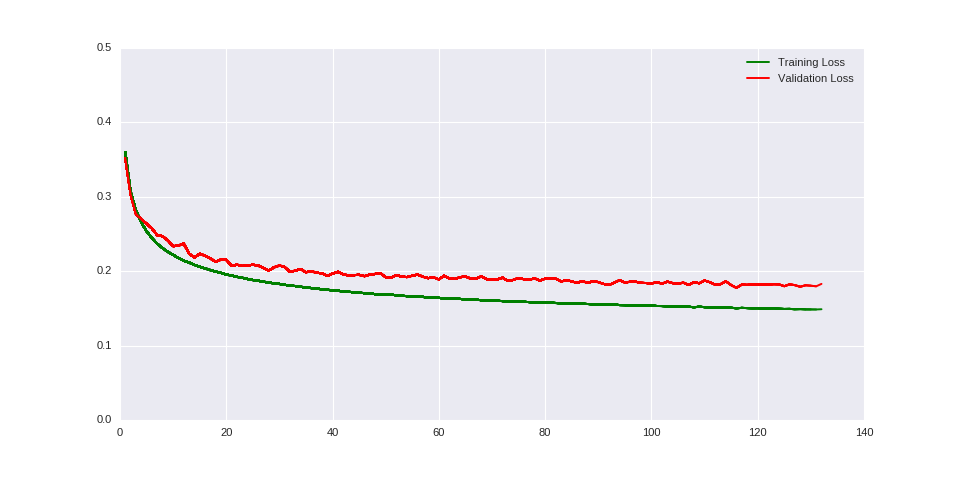

Epoch 1/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3602

2017-03-29 04:16:07,286 : INFO : Found lower val loss for epoch 1 => 0.35237


254767/254767 [==============================] - 160s - loss: 0.3601 - val_loss: 0.3524
Epoch 2/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3070

2017-03-29 04:18:37,245 : INFO : Found lower val loss for epoch 2 => 0.30315


254767/254767 [==============================] - 149s - loss: 0.3069 - val_loss: 0.3031
Epoch 3/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2816

2017-03-29 04:21:08,167 : INFO : Found lower val loss for epoch 3 => 0.27714


254767/254767 [==============================] - 150s - loss: 0.2816 - val_loss: 0.2771
Epoch 4/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2657

2017-03-29 04:23:39,591 : INFO : Found lower val loss for epoch 4 => 0.26943


254767/254767 [==============================] - 151s - loss: 0.2657 - val_loss: 0.2694
Epoch 5/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2537

2017-03-29 04:26:10,861 : INFO : Found lower val loss for epoch 5 => 0.26399


254767/254767 [==============================] - 151s - loss: 0.2537 - val_loss: 0.2640
Epoch 6/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2446

2017-03-29 04:28:41,456 : INFO : Found lower val loss for epoch 6 => 0.25743


254767/254767 [==============================] - 150s - loss: 0.2446 - val_loss: 0.2574
Epoch 7/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2369

2017-03-29 04:31:13,198 : INFO : Found lower val loss for epoch 7 => 0.24843


254767/254767 [==============================] - 151s - loss: 0.2369 - val_loss: 0.2484
Epoch 8/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2311

2017-03-29 04:33:45,071 : INFO : Found lower val loss for epoch 8 => 0.24703


254767/254767 [==============================] - 151s - loss: 0.2311 - val_loss: 0.2470
Epoch 9/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2261

2017-03-29 04:36:16,206 : INFO : Found lower val loss for epoch 9 => 0.2413


254767/254767 [==============================] - 151s - loss: 0.2261 - val_loss: 0.2413
Epoch 10/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2219

2017-03-29 04:38:47,965 : INFO : Found lower val loss for epoch 10 => 0.23363
2017-03-29 04:38:47,967 : INFO : Validation Loss Reduced 10 times
2017-03-29 04:38:47,968 : INFO : Evaluating on Validation Data
2017-03-29 04:40:24,756 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.820 | Top 3: 0.914 | Top 5: 0.980 | F1 Micro: 0.635 | F1 Macro: 0.538
254767/254767 [==============================] - 250s - loss: 0.2219 - val_loss: 0.2336
Epoch 11/200
254767/254767 [==============================] - 152s - loss: 0.2178 - val_loss: 0.2345
Epoch 12/200
254767/254767 [==============================] - 152s - loss: 0.2141 - val_loss: 0.2370
Epoch 13/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2116

2017-03-29 04:48:02,550 : INFO : Found lower val loss for epoch 13 => 0.22348


254767/254767 [==============================] - 151s - loss: 0.2116 - val_loss: 0.2235
Epoch 14/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2086

2017-03-29 04:50:34,149 : INFO : Found lower val loss for epoch 14 => 0.21844


254767/254767 [==============================] - 151s - loss: 0.2086 - val_loss: 0.2184
Epoch 15/200
254767/254767 [==============================] - 151s - loss: 0.2060 - val_loss: 0.2235
Epoch 16/200
254767/254767 [==============================] - 151s - loss: 0.2038 - val_loss: 0.2208
Epoch 17/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2014

2017-03-29 04:58:09,049 : INFO : Found lower val loss for epoch 17 => 0.21702


254767/254767 [==============================] - 151s - loss: 0.2015 - val_loss: 0.2170
Epoch 18/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1995

2017-03-29 05:00:39,835 : INFO : Found lower val loss for epoch 18 => 0.21281


254767/254767 [==============================] - 150s - loss: 0.1995 - val_loss: 0.2128
Epoch 19/200
254767/254767 [==============================] - 151s - loss: 0.1977 - val_loss: 0.2156
Epoch 20/200
254767/254767 [==============================] - 151s - loss: 0.1955 - val_loss: 0.2152
Epoch 21/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1942

2017-03-29 05:08:14,660 : INFO : Found lower val loss for epoch 21 => 0.20729


254767/254767 [==============================] - 151s - loss: 0.1942 - val_loss: 0.2073
Epoch 22/200
254767/254767 [==============================] - 152s - loss: 0.1924 - val_loss: 0.2087
Epoch 23/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1911

2017-03-29 05:13:18,966 : INFO : Found lower val loss for epoch 23 => 0.20697


254767/254767 [==============================] - 152s - loss: 0.1911 - val_loss: 0.2070
Epoch 24/200
254767/254767 [==============================] - 151s - loss: 0.1895 - val_loss: 0.2078
Epoch 25/200
254767/254767 [==============================] - 151s - loss: 0.1881 - val_loss: 0.2087
Epoch 26/200
254767/254767 [==============================] - 151s - loss: 0.1872 - val_loss: 0.2076
Epoch 27/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1858

2017-03-29 05:23:24,172 : INFO : Found lower val loss for epoch 27 => 0.20423


254767/254767 [==============================] - 151s - loss: 0.1858 - val_loss: 0.2042
Epoch 28/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1848

2017-03-29 05:25:56,713 : INFO : Found lower val loss for epoch 28 => 0.20092


254767/254767 [==============================] - 152s - loss: 0.1848 - val_loss: 0.2009
Epoch 29/200
254767/254767 [==============================] - 150s - loss: 0.1836 - val_loss: 0.2053
Epoch 30/200
254767/254767 [==============================] - 148s - loss: 0.1829 - val_loss: 0.2076
Epoch 31/200
254767/254767 [==============================] - 150s - loss: 0.1817 - val_loss: 0.2055
Epoch 32/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1805

2017-03-29 05:35:58,641 : INFO : Found lower val loss for epoch 32 => 0.19885


254767/254767 [==============================] - 151s - loss: 0.1805 - val_loss: 0.1989
Epoch 33/200
254767/254767 [==============================] - 151s - loss: 0.1800 - val_loss: 0.2008
Epoch 34/200
254767/254767 [==============================] - 151s - loss: 0.1790 - val_loss: 0.2027
Epoch 35/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1781

2017-03-29 05:43:34,112 : INFO : Found lower val loss for epoch 35 => 0.19863
2017-03-29 05:43:34,114 : INFO : Validation Loss Reduced 20 times
2017-03-29 05:43:34,115 : INFO : Evaluating on Validation Data
2017-03-29 05:45:06,959 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.598 | Top 3: 0.954 | Top 5: 0.991 | F1 Micro: 0.713 | F1 Macro: 0.646
254767/254767 [==============================] - 246s - loss: 0.1782 - val_loss: 0.1986
Epoch 36/200
254767/254767 [==============================] - 152s - loss: 0.1773 - val_loss: 0.2000
Epoch 37/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1768

2017-03-29 05:50:13,135 : INFO : Found lower val loss for epoch 37 => 0.19791


254767/254767 [==============================] - 152s - loss: 0.1768 - val_loss: 0.1979
Epoch 38/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1756

2017-03-29 05:52:49,377 : INFO : Found lower val loss for epoch 38 => 0.19723


254767/254767 [==============================] - 156s - loss: 0.1756 - val_loss: 0.1972
Epoch 39/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1750

2017-03-29 05:55:21,445 : INFO : Found lower val loss for epoch 39 => 0.1938


254767/254767 [==============================] - 152s - loss: 0.1750 - val_loss: 0.1938
Epoch 40/200
254767/254767 [==============================] - 151s - loss: 0.1743 - val_loss: 0.1967
Epoch 41/200
254767/254767 [==============================] - 150s - loss: 0.1737 - val_loss: 0.1992
Epoch 42/200
254767/254767 [==============================] - 151s - loss: 0.1727 - val_loss: 0.1956
Epoch 43/200
254767/254767 [==============================] - 152s - loss: 0.1723 - val_loss: 0.1944
Epoch 44/200
254767/254767 [==============================] - 151s - loss: 0.1717 - val_loss: 0.1948
Epoch 45/200
254767/254767 [==============================] - 151s - loss: 0.1710 - val_loss: 0.1951
Epoch 46/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1705

2017-03-29 06:13:00,897 : INFO : Found lower val loss for epoch 46 => 0.19334


254767/254767 [==============================] - 151s - loss: 0.1705 - val_loss: 0.1933
Epoch 47/200
254767/254767 [==============================] - 151s - loss: 0.1701 - val_loss: 0.1955
Epoch 48/200
254767/254767 [==============================] - 152s - loss: 0.1692 - val_loss: 0.1963
Epoch 49/200
254767/254767 [==============================] - 151s - loss: 0.1692 - val_loss: 0.1972
Epoch 50/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1688

2017-03-29 06:23:07,905 : INFO : Found lower val loss for epoch 50 => 0.19195


254767/254767 [==============================] - 151s - loss: 0.1688 - val_loss: 0.1919
Epoch 51/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1684

2017-03-29 06:25:40,508 : INFO : Found lower val loss for epoch 51 => 0.19085


254767/254767 [==============================] - 152s - loss: 0.1683 - val_loss: 0.1908
Epoch 52/200
254767/254767 [==============================] - 152s - loss: 0.1678 - val_loss: 0.1950
Epoch 53/200
254767/254767 [==============================] - 151s - loss: 0.1669 - val_loss: 0.1925
Epoch 54/200
254767/254767 [==============================] - 151s - loss: 0.1666 - val_loss: 0.1921
Epoch 55/200
254767/254767 [==============================] - 150s - loss: 0.1663 - val_loss: 0.1940
Epoch 56/200
254767/254767 [==============================] - 150s - loss: 0.1663 - val_loss: 0.1955
Epoch 57/200
254767/254767 [==============================] - 151s - loss: 0.1655 - val_loss: 0.1925
Epoch 58/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1646

2017-03-29 06:43:20,799 : INFO : Found lower val loss for epoch 58 => 0.1907


254767/254767 [==============================] - 152s - loss: 0.1646 - val_loss: 0.1907
Epoch 59/200
254767/254767 [==============================] - 150s - loss: 0.1641 - val_loss: 0.1916
Epoch 60/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1641

2017-03-29 06:48:22,961 : INFO : Found lower val loss for epoch 60 => 0.18906


254767/254767 [==============================] - 151s - loss: 0.1641 - val_loss: 0.1891
Epoch 61/200
254767/254767 [==============================] - 150s - loss: 0.1635 - val_loss: 0.1939
Epoch 62/200
254767/254767 [==============================] - 150s - loss: 0.1632 - val_loss: 0.1904
Epoch 63/200
254767/254767 [==============================] - 151s - loss: 0.1631 - val_loss: 0.1895
Epoch 64/200
254767/254767 [==============================] - 150s - loss: 0.1627 - val_loss: 0.1919
Epoch 65/200
254767/254767 [==============================] - 151s - loss: 0.1622 - val_loss: 0.1930
Epoch 66/200
254767/254767 [==============================] - 149s - loss: 0.1618 - val_loss: 0.1899
Epoch 67/200
254767/254767 [==============================] - 149s - loss: 0.1616 - val_loss: 0.1899
Epoch 68/200
254767/254767 [==============================] - 151s - loss: 0.1611 - val_loss: 0.1931
Epoch 69/200
254767/254767 [==============================] - 150s - loss: 0.1610 - val_loss: 0.1892
Epo

2017-03-29 07:13:28,992 : INFO : Found lower val loss for epoch 70 => 0.1889


254767/254767 [==============================] - 150s - loss: 0.1605 - val_loss: 0.1889
Epoch 71/200
254767/254767 [==============================] - 151s - loss: 0.1601 - val_loss: 0.1890
Epoch 72/200
254767/254767 [==============================] - 150s - loss: 0.1599 - val_loss: 0.1913
Epoch 73/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1596

2017-03-29 07:21:02,217 : INFO : Found lower val loss for epoch 73 => 0.18677
2017-03-29 07:21:02,218 : INFO : Validation Loss Reduced 30 times
2017-03-29 07:21:02,219 : INFO : Evaluating on Validation Data
2017-03-29 07:22:34,928 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.549 | Top 3: 0.960 | Top 5: 0.993 | F1 Micro: 0.735 | F1 Macro: 0.675
254767/254767 [==============================] - 244s - loss: 0.1596 - val_loss: 0.1868
Epoch 74/200
254767/254767 [==============================] - 150s - loss: 0.1592 - val_loss: 0.1883
Epoch 75/200
254767/254767 [==============================] - 151s - loss: 0.1594 - val_loss: 0.1908
Epoch 76/200
254767/254767 [==============================] - 151s - loss: 0.1588 - val_loss: 0.1892
Epoch 77/200
254767/254767 [==============================] - 151s - loss: 0.1585 - val_loss: 0.1884
Epoch 78/200
254767/254767 [==============================] - 150s - loss: 0.1584 - val_loss: 0.1905
Epoch 79/200
254767/254767 [==============================] - 151s - loss: 0.1580 - val_loss: 0.1872
Epoch 80/200
254767/254767 [==============================] - 150s - loss: 0.1578 - val_loss: 0.1900
Epoch 81/200
254767/254767 [==============================] - 151s - loss: 0.1575 - val_loss: 0.1

2017-03-29 07:47:48,710 : INFO : Found lower val loss for epoch 83 => 0.1862


254767/254767 [==============================] - 151s - loss: 0.1570 - val_loss: 0.1862
Epoch 84/200
254767/254767 [==============================] - 152s - loss: 0.1568 - val_loss: 0.1878
Epoch 85/200
254767/254767 [==============================] - 152s - loss: 0.1565 - val_loss: 0.1864
Epoch 86/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1561

2017-03-29 07:55:24,550 : INFO : Found lower val loss for epoch 86 => 0.18422


254767/254767 [==============================] - 151s - loss: 0.1561 - val_loss: 0.1842
Epoch 87/200
254767/254767 [==============================] - 150s - loss: 0.1561 - val_loss: 0.1868
Epoch 88/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1559

2017-03-29 08:00:26,176 : INFO : Found lower val loss for epoch 88 => 0.18416


254767/254767 [==============================] - 151s - loss: 0.1559 - val_loss: 0.1842
Epoch 89/200
254767/254767 [==============================] - 151s - loss: 0.1557 - val_loss: 0.1866
Epoch 90/200
254767/254767 [==============================] - 150s - loss: 0.1556 - val_loss: 0.1853
Epoch 91/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1553

2017-03-29 08:08:00,328 : INFO : Found lower val loss for epoch 91 => 0.18291


254767/254767 [==============================] - 151s - loss: 0.1553 - val_loss: 0.1829
Epoch 92/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1549

2017-03-29 08:10:30,932 : INFO : Found lower val loss for epoch 92 => 0.1815


254767/254767 [==============================] - 150s - loss: 0.1549 - val_loss: 0.1815
Epoch 93/200
254767/254767 [==============================] - 151s - loss: 0.1551 - val_loss: 0.1845
Epoch 94/200
254767/254767 [==============================] - 150s - loss: 0.1545 - val_loss: 0.1879
Epoch 95/200
254767/254767 [==============================] - 150s - loss: 0.1544 - val_loss: 0.1849
Epoch 96/200
254767/254767 [==============================] - 150s - loss: 0.1540 - val_loss: 0.1858
Epoch 97/200
254767/254767 [==============================] - 150s - loss: 0.1540 - val_loss: 0.1859
Epoch 98/200
254767/254767 [==============================] - 151s - loss: 0.1539 - val_loss: 0.1843
Epoch 99/200
254767/254767 [==============================] - 150s - loss: 0.1536 - val_loss: 0.1841
Epoch 100/200
254767/254767 [==============================] - 150s - loss: 0.1537 - val_loss: 0.1834
Epoch 101/200
254767/254767 [==============================] - 150s - loss: 0.1533 - val_loss: 0.1853
E

2017-03-29 08:48:13,542 : INFO : Found lower val loss for epoch 107 => 0.18146


254767/254767 [==============================] - 150s - loss: 0.1522 - val_loss: 0.1815
Epoch 108/200
254767/254767 [==============================] - 150s - loss: 0.1516 - val_loss: 0.1854
Epoch 109/200
254767/254767 [==============================] - 151s - loss: 0.1522 - val_loss: 0.1837
Epoch 110/200
254767/254767 [==============================] - 150s - loss: 0.1517 - val_loss: 0.1875
Epoch 111/200
254767/254767 [==============================] - 150s - loss: 0.1515 - val_loss: 0.1852
Epoch 112/200
254767/254767 [==============================] - 149s - loss: 0.1516 - val_loss: 0.1819
Epoch 113/200
254767/254767 [==============================] - 150s - loss: 0.1513 - val_loss: 0.1825
Epoch 114/200
254767/254767 [==============================] - 150s - loss: 0.1510 - val_loss: 0.1864
Epoch 115/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1508

2017-03-29 09:08:17,562 : INFO : Found lower val loss for epoch 115 => 0.18135


254767/254767 [==============================] - 149s - loss: 0.1508 - val_loss: 0.1814
Epoch 116/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1502

2017-03-29 09:10:49,059 : INFO : Found lower val loss for epoch 116 => 0.17766


254767/254767 [==============================] - 151s - loss: 0.1502 - val_loss: 0.1777
Epoch 117/200
254767/254767 [==============================] - 150s - loss: 0.1507 - val_loss: 0.1820
Epoch 118/200
254767/254767 [==============================] - 150s - loss: 0.1504 - val_loss: 0.1816
Epoch 119/200
254767/254767 [==============================] - 150s - loss: 0.1502 - val_loss: 0.1824
Epoch 120/200
254767/254767 [==============================] - 150s - loss: 0.1503 - val_loss: 0.1823
Epoch 121/200
254767/254767 [==============================] - 150s - loss: 0.1499 - val_loss: 0.1823
Epoch 122/200
254767/254767 [==============================] - 152s - loss: 0.1500 - val_loss: 0.1819
Epoch 123/200
254767/254767 [==============================] - 149s - loss: 0.1501 - val_loss: 0.1826
Epoch 124/200
254767/254767 [==============================] - 150s - loss: 0.1496 - val_loss: 0.1823
Epoch 125/200
254767/254767 [==============================] - 150s - loss: 0.1492 - val_loss: 0

2017-03-29 09:51:00,836 : INFO : Evaluating on Training Data
2017-03-29 09:57:26,374 : INFO : Generating Training Metrics


****** Training Metrics: Cov Err: 1.441 | Top 3: 0.978 | Top 5: 0.997 | F1 Micro: 0.849 | F1 Macro: 0.802


2017-03-29 09:57:32,830 : INFO : Evaluating on Validation Data using saved best weights
2017-03-29 09:59:04,673 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.526 | Top 3: 0.964 | Top 5: 0.993 | F1 Micro: 0.746 | F1 Macro: 0.683


2017-03-29 09:59:06,353 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_large_sample_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_2_batch_2048_nn_parameter_searches.pkl


==================================== NEW PARAM SET ============================================
{'lstm_stack_layers': 3, 'nn_batch_size': 1024, 'classifications_type': 'sections', 'lstm_w_dropout': 0.5, 'lstm_u_dropout': 0.5, 'parts_level': 2, 'lstm_output_size': 500, 'doc2vec_epoch': 8, 'lstm_conv_size': None}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-03-29 10:00:32,090 : INFO : Loading Training Document Stats
2017-03-29 10:00:51,780 : INFO : Loading Training Data from file


Max Size: 34


2017-03-29 10:01:04,613 : INFO : Loading Validation Document Stats


(254767, 34, 200)
(254767, 8)


2017-03-29 10:01:08,461 : INFO : Loading Validation Data from file
2017-03-29 10:01:09,033 : INFO : Loading Validation Labels
2017-03-29 10:01:09,035 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_large_sample_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_2_batch_1024_nn_parameter_searches.pkl


(60957, 34, 200)
(60957, 8)


2017-03-29 10:01:11,725 : INFO : ***************************************************************************************
2017-03-29 10:01:11,726 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_3_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_500_w-drop_0.5_u-drop_0.5_l (None, None, 500)     1402000     lstm_input_2[0][0]               
____________________________________________________________________________________________________
lstm_500_w-drop_0.5_u-drop_0.5_l (None, None, 500)     2002000     lstm_500_w-drop_0.5_u-drop_0.5_la
____________________________________________________________________________________________________
lstm_500_w-drop_0.5_u-drop_0.5_l (None, 500)           2002000     lstm_500_w-drop_0.5_u-drop_0.5_la
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_w-drop_0.5_u-drop_0.5_la
Total params: 5410008
_____________________________________________________________________

<IPython.core.display.Javascript object>


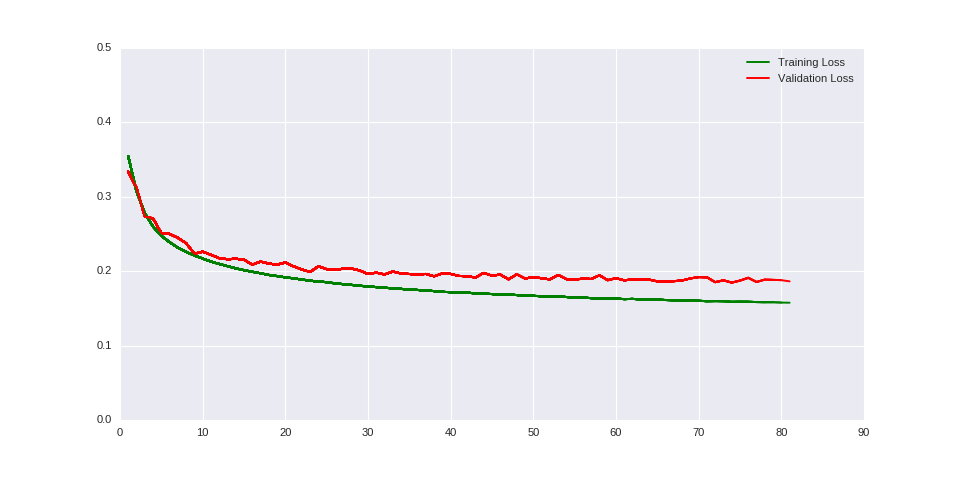

Epoch 1/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3545

2017-03-29 10:06:39,461 : INFO : Found lower val loss for epoch 1 => 0.33374


254767/254767 [==============================] - 270s - loss: 0.3544 - val_loss: 0.3337
Epoch 2/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3070

2017-03-29 10:11:20,566 : INFO : Found lower val loss for epoch 2 => 0.31182


254767/254767 [==============================] - 281s - loss: 0.3070 - val_loss: 0.3118
Epoch 3/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2781

2017-03-29 10:15:59,492 : INFO : Found lower val loss for epoch 3 => 0.27352


254767/254767 [==============================] - 278s - loss: 0.2781 - val_loss: 0.2735
Epoch 4/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2599

2017-03-29 10:20:40,350 : INFO : Found lower val loss for epoch 4 => 0.27094


254767/254767 [==============================] - 280s - loss: 0.2599 - val_loss: 0.2709
Epoch 5/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2476

2017-03-29 10:25:19,556 : INFO : Found lower val loss for epoch 5 => 0.25106


254767/254767 [==============================] - 279s - loss: 0.2476 - val_loss: 0.2511
Epoch 6/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2390

2017-03-29 10:29:59,123 : INFO : Found lower val loss for epoch 6 => 0.25013


254767/254767 [==============================] - 279s - loss: 0.2390 - val_loss: 0.2501
Epoch 7/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2316

2017-03-29 10:34:35,867 : INFO : Found lower val loss for epoch 7 => 0.24481


254767/254767 [==============================] - 276s - loss: 0.2316 - val_loss: 0.2448
Epoch 8/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2259

2017-03-29 10:39:15,743 : INFO : Found lower val loss for epoch 8 => 0.23762


254767/254767 [==============================] - 279s - loss: 0.2259 - val_loss: 0.2376
Epoch 9/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2211

2017-03-29 10:43:54,549 : INFO : Found lower val loss for epoch 9 => 0.2235


254767/254767 [==============================] - 278s - loss: 0.2211 - val_loss: 0.2235
Epoch 10/200
254767/254767 [==============================] - 282s - loss: 0.2170 - val_loss: 0.2262
Epoch 11/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2129

2017-03-29 10:53:15,399 : INFO : Found lower val loss for epoch 11 => 0.22208
2017-03-29 10:53:15,401 : INFO : Validation Loss Reduced 10 times
2017-03-29 10:53:15,403 : INFO : Evaluating on Validation Data
2017-03-29 10:55:42,858 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.756 | Top 3: 0.925 | Top 5: 0.984 | F1 Micro: 0.656 | F1 Macro: 0.569
254767/254767 [==============================] - 426s - loss: 0.2129 - val_loss: 0.2221
Epoch 12/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2097

2017-03-29 11:00:26,724 : INFO : Found lower val loss for epoch 12 => 0.21756


254767/254767 [==============================] - 282s - loss: 0.2097 - val_loss: 0.2176
Epoch 13/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2068

2017-03-29 11:05:10,727 : INFO : Found lower val loss for epoch 13 => 0.21607


254767/254767 [==============================] - 284s - loss: 0.2068 - val_loss: 0.2161
Epoch 14/200
254767/254767 [==============================] - 284s - loss: 0.2038 - val_loss: 0.2167
Epoch 15/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2014

2017-03-29 11:14:37,603 : INFO : Found lower val loss for epoch 15 => 0.21543


254767/254767 [==============================] - 282s - loss: 0.2014 - val_loss: 0.2154
Epoch 16/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1992

2017-03-29 11:19:19,737 : INFO : Found lower val loss for epoch 16 => 0.20875


254767/254767 [==============================] - 282s - loss: 0.1992 - val_loss: 0.2088
Epoch 17/200
254767/254767 [==============================] - 282s - loss: 0.1972 - val_loss: 0.2129
Epoch 18/200
254767/254767 [==============================] - 282s - loss: 0.1950 - val_loss: 0.2103
Epoch 19/200
254767/254767 [==============================] - 283s - loss: 0.1934 - val_loss: 0.2088
Epoch 20/200
254767/254767 [==============================] - 282s - loss: 0.1917 - val_loss: 0.2117
Epoch 21/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1904

2017-03-29 11:42:56,065 : INFO : Found lower val loss for epoch 21 => 0.20652


254767/254767 [==============================] - 284s - loss: 0.1904 - val_loss: 0.2065
Epoch 22/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1888

2017-03-29 11:47:40,157 : INFO : Found lower val loss for epoch 22 => 0.20231


254767/254767 [==============================] - 284s - loss: 0.1888 - val_loss: 0.2023
Epoch 23/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1872

2017-03-29 11:52:24,515 : INFO : Found lower val loss for epoch 23 => 0.19897


254767/254767 [==============================] - 284s - loss: 0.1872 - val_loss: 0.1990
Epoch 24/200
254767/254767 [==============================] - 286s - loss: 0.1860 - val_loss: 0.2066
Epoch 25/200
254767/254767 [==============================] - 282s - loss: 0.1853 - val_loss: 0.2027
Epoch 26/200
254767/254767 [==============================] - 283s - loss: 0.1837 - val_loss: 0.2017
Epoch 27/200
254767/254767 [==============================] - 283s - loss: 0.1826 - val_loss: 0.2034
Epoch 28/200
254767/254767 [==============================] - 284s - loss: 0.1816 - val_loss: 0.2036
Epoch 29/200
254767/254767 [==============================] - 282s - loss: 0.1804 - val_loss: 0.2010
Epoch 30/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1795

2017-03-29 12:25:29,987 : INFO : Found lower val loss for epoch 30 => 0.1962


254767/254767 [==============================] - 282s - loss: 0.1795 - val_loss: 0.1962
Epoch 31/200
254767/254767 [==============================] - 284s - loss: 0.1786 - val_loss: 0.1980
Epoch 32/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1778

2017-03-29 12:34:57,602 : INFO : Found lower val loss for epoch 32 => 0.19564


254767/254767 [==============================] - 283s - loss: 0.1778 - val_loss: 0.1956
Epoch 33/200
254767/254767 [==============================] - 283s - loss: 0.1770 - val_loss: 0.1995
Epoch 34/200
254767/254767 [==============================] - 285s - loss: 0.1762 - val_loss: 0.1969
Epoch 35/200
254767/254767 [==============================] - 282s - loss: 0.1752 - val_loss: 0.1962
Epoch 36/200
254767/254767 [==============================] - 283s - loss: 0.1748 - val_loss: 0.1957
Epoch 37/200
254767/254767 [==============================] - 283s - loss: 0.1740 - val_loss: 0.1963
Epoch 38/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1733

2017-03-29 13:03:18,773 : INFO : Found lower val loss for epoch 38 => 0.19313
2017-03-29 13:03:18,774 : INFO : Validation Loss Reduced 20 times
2017-03-29 13:03:18,775 : INFO : Evaluating on Validation Data
2017-03-29 13:05:58,765 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.585 | Top 3: 0.956 | Top 5: 0.991 | F1 Micro: 0.720 | F1 Macro: 0.652
254767/254767 [==============================] - 443s - loss: 0.1733 - val_loss: 0.1931
Epoch 39/200
254767/254767 [==============================] - 289s - loss: 0.1722 - val_loss: 0.1970
Epoch 40/200
254767/254767 [==============================] - 282s - loss: 0.1719 - val_loss: 0.1963
Epoch 41/200
254767/254767 [==============================] - 279s - loss: 0.1711 - val_loss: 0.1936
Epoch 42/200
254767/254767 [==============================] - 255s - loss: 0.1711 - val_loss: 0.1933
Epoch 43/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1703

2017-03-29 13:28:31,114 : INFO : Found lower val loss for epoch 43 => 0.19154


254767/254767 [==============================] - 243s - loss: 0.1702 - val_loss: 0.1915
Epoch 44/200
254767/254767 [==============================] - 242s - loss: 0.1697 - val_loss: 0.1977
Epoch 45/200
254767/254767 [==============================] - 241s - loss: 0.1693 - val_loss: 0.1940
Epoch 46/200
254767/254767 [==============================] - 241s - loss: 0.1687 - val_loss: 0.1955
Epoch 47/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1686

2017-03-29 13:44:38,493 : INFO : Found lower val loss for epoch 47 => 0.1891


254767/254767 [==============================] - 241s - loss: 0.1685 - val_loss: 0.1891
Epoch 48/200
254767/254767 [==============================] - 242s - loss: 0.1679 - val_loss: 0.1957
Epoch 49/200
254767/254767 [==============================] - 239s - loss: 0.1670 - val_loss: 0.1902
Epoch 50/200
254767/254767 [==============================] - 241s - loss: 0.1669 - val_loss: 0.1921
Epoch 51/200
254767/254767 [==============================] - 240s - loss: 0.1664 - val_loss: 0.1905
Epoch 52/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1658

2017-03-29 14:04:43,426 : INFO : Found lower val loss for epoch 52 => 0.189


254767/254767 [==============================] - 240s - loss: 0.1658 - val_loss: 0.1890
Epoch 53/200
254767/254767 [==============================] - 241s - loss: 0.1660 - val_loss: 0.1950
Epoch 54/200
254767/254767 [==============================] - 241s - loss: 0.1653 - val_loss: 0.1893
Epoch 55/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1645

2017-03-29 14:16:48,237 : INFO : Found lower val loss for epoch 55 => 0.18868


254767/254767 [==============================] - 241s - loss: 0.1645 - val_loss: 0.1887
Epoch 56/200
254767/254767 [==============================] - 239s - loss: 0.1645 - val_loss: 0.1901
Epoch 57/200
254767/254767 [==============================] - 241s - loss: 0.1638 - val_loss: 0.1895
Epoch 58/200
254767/254767 [==============================] - 240s - loss: 0.1634 - val_loss: 0.1945
Epoch 59/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1635

2017-03-29 14:32:50,625 : INFO : Found lower val loss for epoch 59 => 0.18794


254767/254767 [==============================] - 240s - loss: 0.1635 - val_loss: 0.1879
Epoch 60/200
254767/254767 [==============================] - 256s - loss: 0.1632 - val_loss: 0.1907
Epoch 61/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1625

2017-03-29 14:41:48,618 : INFO : Found lower val loss for epoch 61 => 0.18769


254767/254767 [==============================] - 281s - loss: 0.1625 - val_loss: 0.1877
Epoch 62/200
254767/254767 [==============================] - 282s - loss: 0.1628 - val_loss: 0.1891
Epoch 63/200
254767/254767 [==============================] - 282s - loss: 0.1621 - val_loss: 0.1887
Epoch 64/200
254767/254767 [==============================] - 282s - loss: 0.1617 - val_loss: 0.1887
Epoch 65/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1618

2017-03-29 15:00:38,566 : INFO : Found lower val loss for epoch 65 => 0.18632


254767/254767 [==============================] - 282s - loss: 0.1618 - val_loss: 0.1863
Epoch 66/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1613

2017-03-29 15:05:20,437 : INFO : Found lower val loss for epoch 66 => 0.18616


254767/254767 [==============================] - 281s - loss: 0.1613 - val_loss: 0.1862
Epoch 67/200
254767/254767 [==============================] - 283s - loss: 0.1610 - val_loss: 0.1866
Epoch 68/200
254767/254767 [==============================] - 280s - loss: 0.1609 - val_loss: 0.1875
Epoch 69/200
254767/254767 [==============================] - 284s - loss: 0.1604 - val_loss: 0.1903
Epoch 70/200
254767/254767 [==============================] - 281s - loss: 0.1603 - val_loss: 0.1921
Epoch 71/200
254767/254767 [==============================] - 284s - loss: 0.1597 - val_loss: 0.1918
Epoch 72/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1598

2017-03-29 15:33:36,665 : INFO : Found lower val loss for epoch 72 => 0.18525


254767/254767 [==============================] - 281s - loss: 0.1598 - val_loss: 0.1853
Epoch 73/200
254767/254767 [==============================] - 282s - loss: 0.1597 - val_loss: 0.1878
Epoch 74/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1588

2017-03-29 15:43:00,589 : INFO : Found lower val loss for epoch 74 => 0.18467
2017-03-29 15:43:00,590 : INFO : Validation Loss Reduced 30 times
2017-03-29 15:43:00,591 : INFO : Evaluating on Validation Data
2017-03-29 15:45:23,219 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.550 | Top 3: 0.960 | Top 5: 0.992 | F1 Micro: 0.738 | F1 Macro: 0.678
254767/254767 [==============================] - 425s - loss: 0.1588 - val_loss: 0.1847
Epoch 75/200
254767/254767 [==============================] - 283s - loss: 0.1591 - val_loss: 0.1874
Epoch 76/200
254767/254767 [==============================] - 293s - loss: 0.1590 - val_loss: 0.1911
Epoch 77/200
254767/254767 [==============================] - 293s - loss: 0.1585 - val_loss: 0.1855
Epoch 78/200
254767/254767 [==============================] - 294s - loss: 0.1583 - val_loss: 0.1887
Epoch 79/200
254767/254767 [==============================] - 294s - loss: 0.1583 - val_loss: 0.1884
Epoch 80/200
254767/254767 [==============================] - 295s - loss: 0.1578 - val_loss: 0.1880
Epoch 81/200
254767/254767 [==============================] - 295s - loss: 0.1576 - val_loss: 0.1864
Epoch 82/200
 37888/254767 [===>..........................] - ETA: 244s - loss: 0.1561

In [ ]:
%matplotlib notebook

for GLOBAL_PARAMS in GLOBAL_PARMS_TO_RUN:
    
    print '==================================== NEW PARAM SET ============================================'
    print {k:v for k,v in GLOBAL_PARAMS.items() if k != 'classifications'}
    
    classifications = GLOBAL_PARAMS['classifications']
    classifications_type = GLOBAL_PARAMS['classifications_type']
    classifier_file = TYPE_CLASSIFIER.format(classifications_type)
    
    PARTS_LEVEL = GLOBAL_PARAMS['parts_level']
    
    
    placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
    GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
    placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

    epoch = GLOBAL_PARAMS['doc2vec_epoch']

    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    doc2vec_model = None

    training_doc_stats_file = os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, "extended_pv_training_doc_stats.pkl")
    validation_doc_stats_file = os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, "extended_pv_validation_doc_stats.pkl")

    print GLOBAL_VARS.MODEL_NAME
    
#     print os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)
#     if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
#         doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX), mmap=DOC2VEC_MMAP)
#         doc2vec_model.workers = NUM_CORES
#         GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
#     else:
#         info("Couldnt find the doc2vec model with epoch {}".format(epoch))
#         raise Exception()
    
    time.sleep(0.2)
    
    info("Loading Training Document Stats")
    doc_stats = pickle.load(open(training_doc_stats_file, "r"))
    
    MAX_SIZE = 1 # for document vector
    if PARTS_LEVEL >= LEVEL_DIVISIONS:
        MAX_PARTS = int(np.max([len(doc_stats.doc_parts[d]) for d in doc_stats.docids]))
        MAX_SIZE += MAX_PARTS

    if PARTS_LEVEL >= LEVEL_CHUNKS:
        MAX_PART_CHUNKS = int(np.max([len(doc_stats.doc_part_chunks[d]) for d in doc_stats.docids]))
        MAX_SIZE += MAX_PART_CHUNKS

    print "Max Size: {}".format(MAX_SIZE)
    
    X, y = get_training_data(doc2vec_model, classifications, classifications_type, doc_stats, MAX_SIZE, DOC2VEC_SIZE)
    print X.shape
    print y.shape
    
    validation_dict = None
#     validation_dict = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_DICT)))
    info("Loading Validation Document Stats")
    validation_doc_stats = pickle.load(open(validation_doc_stats_file, "r"))
    Xv, yv = get_validation_data(validation_dict, classifications, classifications_type, validation_doc_stats, 
                             MAX_SIZE, DOC2VEC_SIZE)
    print Xv.shape
    print yv.shape
    
    
    NN_OUTPUT_NEURONS = len(classifications)
    EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
    EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

    NN_MAX_EPOCHS = 200
    NN_PARAM_SAMPLE_SEED = 1234

    NN_BATCH_SIZE = GLOBAL_PARAMS['nn_batch_size']

    MODEL_VERBOSITY = 1

    NN_OPTIMIZER = 'rmsprop'
    # NN_OPTIMIZER = 'adam'

    to_skip = []

    load_existing_results = True
    save_results = True


    np.random.seed(NN_SEED)
    
    
    
    ################################################################################
    ############### Actual Training


    # load previous finshed results so we dont redo them
    param_results_dict = {}
    if load_existing_results:
        param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
        if os.path.exists(param_results_path):
            info('Loading Previous results from {}'.format(param_results_path))
            param_results_dict = pickle.load(open(param_results_path))
        else:
            info('No Previous results exist in {}'.format(param_results_path))


    # create nn parameter search directory
    if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
        os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

    start_time = time.time()
    lstm_output_size = GLOBAL_PARAMS['lstm_output_size']
    w_dropout_do = GLOBAL_PARAMS['lstm_w_dropout']
    u_dropout_do = GLOBAL_PARAMS['lstm_u_dropout']
    stack_layers = GLOBAL_PARAMS['lstm_stack_layers']
    conv_size = GLOBAL_PARAMS['lstm_conv_size']

    GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
        lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
    )

    if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
        print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue

    info('***************************************************************************************')
    info(GLOBAL_VARS.NN_MODEL_NAME)

    # creating the actual keras model
    model = create_keras_rnn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                                  lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size)
    model.summary()

    # callbacks for early stopping and for generating validation metrics
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                  patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
    metrics_callback = MetricsCallback()


    # Model Fitting
    %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
                              nb_epoch=NN_MAX_EPOCHS, verbose=MODEL_VERBOSITY, \
                              callbacks=[early_stopper, metrics_callback])
    
    
    time.sleep(0.2)
    info('Evaluating on Training Data')
    yp = model.predict(X) # get raw probability for predicted labels
    yp_binary = get_binary_0_5(yp) # use 0.5 as threshold for setting labels to 0 or 1
    #print yvp
    info('Generating Training Metrics')
    training_metrics = get_metrics(y, yp, yp_binary)
    print "****** Training Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    training_metrics['coverage_error'], training_metrics['top_3'], training_metrics['top_5'], 
    training_metrics['f1_micro'], training_metrics['f1_macro'])
    
    
    time.sleep(0.2)
    info('Evaluating on Validation Data using saved best weights')
    model.set_weights(metrics_callback.best_weights)
    yvp = model.predict(Xv) # get raw probability for predicted labels
    yvp_binary = get_binary_0_5(yvp) # use 0.5 as threshold for setting labels to 0 or 1
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])
    best_validation_metrics = validation_metrics
    
    time.sleep(0.2)
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

    duration = time.time() - start_time
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

    del history, metrics_callback, model

    if save_results:
        if load_existing_results:
            if os.path.exists(param_results_path):
                info('Loading Previous results from {}'.format(param_results_path))
                loaded_param_results_dict = pickle.load(open(param_results_path))
                param_results_dict.update(loaded_param_results_dict)

        pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE))), 'w'))
        

In [133]:
classifications = valid_classes
classifications_type = 'sections'
classifier_file = TYPE_CLASSIFIER.format(classifications_type)

#### This is where we set which level we want to train for
0 -> Use only the document vector  
1 -> Use the document vector and the vectors for abstract, description, claims  
2 -> Use the document vector and the vectors for abstract, description, claims plus the chunk vectors

In [134]:
LEVEL_DOC = 0
LEVEL_DIVISIONS = 1
LEVEL_CHUNKS = 2

PARTS_LEVEL = LEVEL_DIVISIONS

# Load the Doc2vec model

In [135]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 8
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100000 # report vocab progress every x documents

DOC2VEC_MMAP = 'r'
# DOC2VEC_MMAP = None

ZERO_VECTOR = [0] * DOC2VEC_SIZE

In [136]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

epoch = 8

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
doc2vec_model = None

training_doc_stats_file = os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, "extended_pv_training_doc_stats.pkl")
validation_doc_stats_file = os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, "extended_pv_validation_doc_stats.pkl")

print GLOBAL_VARS.MODEL_NAME

doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


In [56]:
%%time
print os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX), mmap=DOC2VEC_MMAP)
    doc2vec_model.workers = NUM_CORES
    GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
else:
    info("Couldnt find the doc2vec model with epoch {}".format(epoch))
    raise Exception()

2017-03-26 05:38:34,135 : INFO : loading Doc2Vec object from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_12/model


/mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_12/model


2017-03-26 05:39:08,359 : INFO : loading docvecs recursively from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_12/model.docvecs.* with mmap=r
2017-03-26 05:39:08,361 : INFO : loading doctag_syn0 from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_12/model.docvecs.doctag_syn0.npy with mmap=r
2017-03-26 05:39:08,398 : INFO : loading syn1neg from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_12/model.syn1neg.npy with mmap=r
2017-03-26 05:39:08,444 : INFO : loading syn0 from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_c

CPU times: user 29.5 s, sys: 5.38 s, total: 34.9 s
Wall time: 37.9 s


# Get the Data to use for Training

#### Create/Load Training Document Stats 
these contain references to the ids of the parts of each document 

(ex. 059884 -> ["059884_abstract", "059884_abstract", "059884_abstract", "059884_abstract_part-1",...]) 

so we know what to load when constructing the training and validation matrices

In [116]:
%%time
if not os.path.exists(training_doc_stats_file):
    info("Creating Training Document Stats")
    doc_stats = FixedDocumentsStatsGenerator(training_preprocessed_files_prefix)
    doc_stats.get_stats()
    pickle.dump(doc_stats, open(training_doc_stats_file, "w"))
else:
    info("Loading Training Document Stats")
    doc_stats = pickle.load(open(training_doc_stats_file, "r"))

2017-03-27 20:39:48,969 : INFO : Loading Training Document Stats


CPU times: user 20.5 s, sys: 1.78 s, total: 22.3 s
Wall time: 22.3 s


In [137]:
MAX_SIZE = 1 # for document vector
if PARTS_LEVEL >= LEVEL_DIVISIONS:
    MAX_PARTS = int(np.max([len(doc_stats.doc_parts[d]) for d in doc_stats.docids]))
    MAX_SIZE += MAX_PARTS

if PARTS_LEVEL >= LEVEL_CHUNKS:
    MAX_PART_CHUNKS = int(np.max([len(doc_stats.doc_part_chunks[d]) for d in doc_stats.docids]))
    MAX_SIZE += MAX_PART_CHUNKS
    
print "Max Size: {}".format(MAX_SIZE)

Max Size: 4


#### Get Training Data Matrices

In [138]:
%%time
X, y = get_training_data(doc2vec_model, classifications, classifications_type, doc_stats, MAX_SIZE, DOC2VEC_SIZE)

2017-03-27 23:42:43,521 : INFO : Loading Training Data from file


CPU times: user 4 ms, sys: 3.46 s, total: 3.46 s
Wall time: 3.45 s


In [139]:
import sys
print sys.getsizeof(X)
print X.shape
print y.shape

815254528
(254767, 4, 200)
(254767, 8)


#### Create/Load Validation Doc Stats

In [140]:
validation_dict = None

Load Validation Dict. This is the dictionary that contains the precomputed doc2vec vectors for each document, document part and chunk

In [77]:
%%time
validation_dict = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_DICT)))

CPU times: user 2min 56s, sys: 3.98 s, total: 3min
Wall time: 3min 2s


In [121]:
%%time
if not os.path.exists(validation_doc_stats_file):
    validation_doc_stats = FixedDocumentsStatsGenerator(validation_preprocessed_files_prefix)
    validation_doc_stats.get_stats()
    pickle.dump(validation_doc_stats, open(validation_doc_stats_file, "w"))
else:
    info("Loading Validation Document Stats")
    validation_doc_stats = pickle.load(open(validation_doc_stats_file, "r"))

2017-03-27 20:40:11,431 : INFO : Loading Validation Document Stats


CPU times: user 4.13 s, sys: 152 ms, total: 4.28 s
Wall time: 4.28 s


#### Get Validation Data Matrices

In [141]:
%%time
Xv, yv = get_validation_data(validation_dict, classifications, classifications_type, validation_doc_stats, 
                             MAX_SIZE, DOC2VEC_SIZE)

2017-03-27 23:42:58,506 : INFO : Loading Validation Data from file
2017-03-27 23:42:59,195 : INFO : Loading Validation Labels


CPU times: user 0 ns, sys: 664 ms, total: 664 ms
Wall time: 691 ms


In [142]:
del validation_dict

In [143]:
print Xv.shape
print yv.shape

(60957, 4, 200)
(60957, 8)


# LSTM Parameters and training functions

In [144]:
def create_keras_rnn_model(input_size, output_size, lstm_output_size, w_dropout_do, u_dropout_do, 
                           stack_layers=1, conv_size=None):
    
    model= Sequential()
#     model.add(Masking(mask_value=0., input_shape=(MAX_SIZE, input_size)))
    if conv_size:
        model.add(Convolution1D(nb_filter=conv_size, input_shape=(MAX_SIZE, input_size), filter_length=3, 
                                border_mode='same', activation='relu'))
        model.add(MaxPooling1D(pool_length=2))
    for i in range(stack_layers):
        model.add(LSTM(lstm_output_size, input_dim=input_size, dropout_W=w_dropout_do, dropout_U=u_dropout_do,
                       return_sequences=False if i+1 == stack_layers else True,
                  name='lstm_{}_w-drop_{}_u-drop_{}_layer_{}'.format(lstm_output_size, str(u_dropout_do), str(w_dropout_do), str(i+1))))
    model.add(Dense(output_size, activation='sigmoid', name='sigmoid_output'))
    model.compile(optimizer=NN_OPTIMIZER, loss='binary_crossentropy')
    return model

In [145]:
# minimum change in val_loss from previous epoch to register as a decrease
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
# how many epochs to wait when there is no decrease in val_loss before early stopping
early_stopper_patience = {
    'sections': 15,
    'classes': 15,
    'subclasses': 15
}
# number of epochs after which we do periodic evaluation of validation metrics
epochs_before_validation = {
    'sections': 10,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.5},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [146]:
class MetricsCallback(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    def __init__():
        MetricsCallback.EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
        MetricsCallback.GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
        MetricsCallback.GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallback.GRAPH_MIN, MetricsCallback.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            #print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict(Xv)
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

#### Parameters for LSTM

In [151]:
NN_OUTPUT_NEURONS = len(classifications)

EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

NN_MAX_EPOCHS = 200
NN_RANDOM_SEARCH_BUDGET = 30
NN_PARAM_SAMPLE_SEED = 1234

NN_BATCH_SIZE = 2048

MODEL_VERBOSITY = 1

NN_OPTIMIZER = 'rmsprop'
# NN_OPTIMIZER = 'adam'

to_skip = []

load_existing_results = True
save_results = True

# parameters to use when doing random hyperparameter search
lstm_output_sizes = [200,500,1000]
w_dropout_options = [0.2,None,0.5]
u_dropout_options = [0.2,None,0.5]
stack_layers_options = [1,2]
conv_size_options = [None]
# conv_size_options = [None, 32,100,200,300]


# Uncomment for Specific Configuration
NN_RANDOM_SEARCH_BUDGET = 2
lstm_output_sizes = [500,1000]
w_dropout_options = [0.5]
u_dropout_options = [0.5]
stack_layers_options = [3]
conv_size_options = [None]

np.random.seed(NN_SEED)

# Actual Training

2017-03-27 23:55:07,969 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_large_sample_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_1_batch_2048_nn_parameter_searches.pkl
2017-03-27 23:56:22,986 : INFO : ***************************************************************************************
2017-03-27 23:56:22,988 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_3_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_500_w-drop_0.5_u-drop_0.5_l (None, None, 500)     1402000     lstm_input_15[0][0]              
____________________________________________________________________________________________________
lstm_500_w-drop_0.5_u-drop_0.5_l (None, None, 500)     2002000     lstm_500_w-drop_0.5_u-drop_0.5_la
____________________________________________________________________________________________________
lstm_500_w-drop_0.5_u-drop_0.5_l (None, 500)           2002000     lstm_500_w-drop_0.5_u-drop_0.5_la
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_w-drop_0.5_u-drop_0.5_la
Total params: 5410008
_____________________________________________________________________

<IPython.core.display.Javascript object>


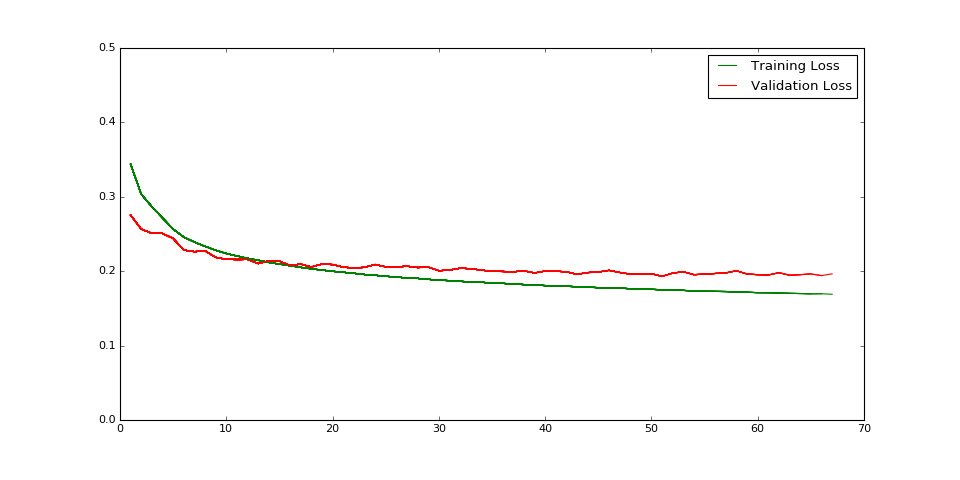

Epoch 1/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3438

2017-03-27 23:58:07,017 : INFO : Found lower val loss for epoch 1 => 0.27536


254767/254767 [==============================] - 36s - loss: 0.3437 - val_loss: 0.2754
Epoch 2/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3035

2017-03-27 23:58:43,064 : INFO : Found lower val loss for epoch 2 => 0.25655


254767/254767 [==============================] - 36s - loss: 0.3035 - val_loss: 0.2565
Epoch 3/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2867

2017-03-27 23:59:18,920 : INFO : Found lower val loss for epoch 3 => 0.251


254767/254767 [==============================] - 35s - loss: 0.2866 - val_loss: 0.2510
Epoch 4/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2716

2017-03-27 23:59:54,595 : INFO : Found lower val loss for epoch 4 => 0.25074


254767/254767 [==============================] - 35s - loss: 0.2716 - val_loss: 0.2507
Epoch 5/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2566

2017-03-28 00:00:31,194 : INFO : Found lower val loss for epoch 5 => 0.24403


254767/254767 [==============================] - 36s - loss: 0.2565 - val_loss: 0.2440
Epoch 6/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2459

2017-03-28 00:01:07,502 : INFO : Found lower val loss for epoch 6 => 0.22839


254767/254767 [==============================] - 36s - loss: 0.2459 - val_loss: 0.2284
Epoch 7/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2391

2017-03-28 00:01:46,688 : INFO : Found lower val loss for epoch 7 => 0.22628


254767/254767 [==============================] - 39s - loss: 0.2391 - val_loss: 0.2263
Epoch 8/200
254767/254767 [==============================] - 39s - loss: 0.2334 - val_loss: 0.2273
Epoch 9/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2281

2017-03-28 00:03:09,669 : INFO : Found lower val loss for epoch 9 => 0.21857


254767/254767 [==============================] - 42s - loss: 0.2282 - val_loss: 0.2186
Epoch 10/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2238

2017-03-28 00:03:52,888 : INFO : Found lower val loss for epoch 10 => 0.21601


254767/254767 [==============================] - 43s - loss: 0.2238 - val_loss: 0.2160
Epoch 11/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2204

2017-03-28 00:04:38,136 : INFO : Found lower val loss for epoch 11 => 0.21568
2017-03-28 00:04:38,137 : INFO : Validation Loss Reduced 10 times
2017-03-28 00:04:38,138 : INFO : Evaluating on Validation Data
2017-03-28 00:05:09,389 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.712 | Top 3: 0.933 | Top 5: 0.987 | F1 Micro: 0.674 | F1 Macro: 0.597
254767/254767 [==============================] - 78s - loss: 0.2205 - val_loss: 0.2157
Epoch 12/200
254767/254767 [==============================] - 36s - loss: 0.2173 - val_loss: 0.2159
Epoch 13/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2147

2017-03-28 00:06:32,478 : INFO : Found lower val loss for epoch 13 => 0.2103


254767/254767 [==============================] - 44s - loss: 0.2147 - val_loss: 0.2103
Epoch 14/200
254767/254767 [==============================] - 44s - loss: 0.2118 - val_loss: 0.2139
Epoch 15/200
254767/254767 [==============================] - 46s - loss: 0.2095 - val_loss: 0.2134
Epoch 16/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2074

2017-03-28 00:08:49,522 : INFO : Found lower val loss for epoch 16 => 0.2078


254767/254767 [==============================] - 45s - loss: 0.2074 - val_loss: 0.2078
Epoch 17/200
254767/254767 [==============================] - 46s - loss: 0.2051 - val_loss: 0.2095
Epoch 18/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2032

2017-03-28 00:10:21,122 : INFO : Found lower val loss for epoch 18 => 0.20566


254767/254767 [==============================] - 45s - loss: 0.2032 - val_loss: 0.2057
Epoch 19/200
254767/254767 [==============================] - 46s - loss: 0.2015 - val_loss: 0.2096
Epoch 20/200
254767/254767 [==============================] - 45s - loss: 0.1999 - val_loss: 0.2089
Epoch 21/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1985

2017-03-28 00:12:38,664 : INFO : Found lower val loss for epoch 21 => 0.20538


254767/254767 [==============================] - 45s - loss: 0.1985 - val_loss: 0.2054
Epoch 22/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1972

2017-03-28 00:13:23,584 : INFO : Found lower val loss for epoch 22 => 0.20442


254767/254767 [==============================] - 44s - loss: 0.1972 - val_loss: 0.2044
Epoch 23/200
254767/254767 [==============================] - 45s - loss: 0.1955 - val_loss: 0.2052
Epoch 24/200
254767/254767 [==============================] - 47s - loss: 0.1945 - val_loss: 0.2090
Epoch 25/200
254767/254767 [==============================] - 68s - loss: 0.1932 - val_loss: 0.2058
Epoch 26/200
254767/254767 [==============================] - 65s - loss: 0.1921 - val_loss: 0.2057
Epoch 27/200
254767/254767 [==============================] - 49s - loss: 0.1909 - val_loss: 0.2067
Epoch 28/200
254767/254767 [==============================] - 63s - loss: 0.1903 - val_loss: 0.2049
Epoch 29/200
254767/254767 [==============================] - 57s - loss: 0.1891 - val_loss: 0.2054
Epoch 30/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1880

2017-03-28 00:21:02,708 : INFO : Found lower val loss for epoch 30 => 0.20064


254767/254767 [==============================] - 63s - loss: 0.1880 - val_loss: 0.2006
Epoch 31/200
254767/254767 [==============================] - 63s - loss: 0.1873 - val_loss: 0.2015
Epoch 32/200
254767/254767 [==============================] - 57s - loss: 0.1863 - val_loss: 0.2040
Epoch 33/200
254767/254767 [==============================] - 68s - loss: 0.1856 - val_loss: 0.2033
Epoch 34/200
254767/254767 [==============================] - 62s - loss: 0.1851 - val_loss: 0.2014
Epoch 35/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1842

2017-03-28 00:26:14,837 : INFO : Found lower val loss for epoch 35 => 0.1998


254767/254767 [==============================] - 60s - loss: 0.1841 - val_loss: 0.1998
Epoch 36/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1837

2017-03-28 00:27:24,470 : INFO : Found lower val loss for epoch 36 => 0.19964


254767/254767 [==============================] - 69s - loss: 0.1837 - val_loss: 0.1996
Epoch 37/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1826

2017-03-28 00:28:16,583 : INFO : Found lower val loss for epoch 37 => 0.19917


254767/254767 [==============================] - 52s - loss: 0.1826 - val_loss: 0.1992
Epoch 38/200
254767/254767 [==============================] - 77s - loss: 0.1821 - val_loss: 0.2005
Epoch 39/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1814

2017-03-28 00:30:48,429 : INFO : Found lower val loss for epoch 39 => 0.19766
2017-03-28 00:30:48,431 : INFO : Validation Loss Reduced 20 times
2017-03-28 00:30:48,433 : INFO : Evaluating on Validation Data
2017-03-28 00:31:38,168 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.613 | Top 3: 0.950 | Top 5: 0.991 | F1 Micro: 0.712 | F1 Macro: 0.647
254767/254767 [==============================] - 126s - loss: 0.1814 - val_loss: 0.1977
Epoch 40/200
254767/254767 [==============================] - 57s - loss: 0.1807 - val_loss: 0.2002
Epoch 41/200
254767/254767 [==============================] - 70s - loss: 0.1799 - val_loss: 0.2000
Epoch 42/200
254767/254767 [==============================] - 61s - loss: 0.1797 - val_loss: 0.1992
Epoch 43/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1792

2017-03-28 00:35:53,229 : INFO : Found lower val loss for epoch 43 => 0.19581


254767/254767 [==============================] - 63s - loss: 0.1792 - val_loss: 0.1958
Epoch 44/200
254767/254767 [==============================] - 67s - loss: 0.1785 - val_loss: 0.1981
Epoch 45/200
254767/254767 [==============================] - 56s - loss: 0.1779 - val_loss: 0.1989
Epoch 46/200
254767/254767 [==============================] - 64s - loss: 0.1777 - val_loss: 0.2011
Epoch 47/200
254767/254767 [==============================] - 56s - loss: 0.1771 - val_loss: 0.1983
Epoch 48/200
254767/254767 [==============================] - 69s - loss: 0.1765 - val_loss: 0.1961
Epoch 49/200
254767/254767 [==============================] - 69s - loss: 0.1759 - val_loss: 0.1961
Epoch 50/200
254767/254767 [==============================] - 55s - loss: 0.1756 - val_loss: 0.1966
Epoch 51/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1751

2017-03-28 00:44:15,888 : INFO : Found lower val loss for epoch 51 => 0.19307


254767/254767 [==============================] - 64s - loss: 0.1751 - val_loss: 0.1931
Epoch 52/200
254767/254767 [==============================] - 53s - loss: 0.1746 - val_loss: 0.1974
Epoch 53/200
254767/254767 [==============================] - 67s - loss: 0.1742 - val_loss: 0.1992
Epoch 54/200
254767/254767 [==============================] - 59s - loss: 0.1734 - val_loss: 0.1954
Epoch 55/200
254767/254767 [==============================] - 61s - loss: 0.1730 - val_loss: 0.1960
Epoch 56/200
254767/254767 [==============================] - 76s - loss: 0.1728 - val_loss: 0.1969
Epoch 57/200
254767/254767 [==============================] - 73s - loss: 0.1727 - val_loss: 0.1977
Epoch 58/200
254767/254767 [==============================] - 48s - loss: 0.1721 - val_loss: 0.2006
Epoch 59/200
254767/254767 [==============================] - 71s - loss: 0.1717 - val_loss: 0.1962
Epoch 60/200
254767/254767 [==============================] - 71s - loss: 0.1712 - val_loss: 0.1953
Epoch 61/200


2017-03-28 01:01:06,960 : INFO : Evaluating on Training Data
2017-03-28 01:04:06,041 : INFO : Generating Training Metrics


****** Training Metrics: Cov Err: 1.501 | Top 3: 0.971 | Top 5: 0.995 | F1 Micro: 0.819 | F1 Macro: 0.755


2017-03-28 01:04:13,577 : INFO : Evaluating on Validation Data using saved best weights
2017-03-28 01:04:56,049 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.586 | Top 3: 0.953 | Top 5: 0.991 | F1 Micro: 0.724 | F1 Macro: 0.660


2017-03-28 01:04:57,811 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_large_sample_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_1_batch_2048_nn_parameter_searches.pkl


skipping: lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_3_conv_None


In [152]:
%matplotlib notebook

# random search for parameters
param_sampler = ParameterSampler({
    'lstm_output_size':lstm_output_sizes,
    'w_dropout':w_dropout_options,
    'u_dropout':u_dropout_options,
    'stack_layers':stack_layers_options,
    'conv_size':conv_size_options,
}, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)

# load previous finshed results so we dont redo them
param_results_dict = {}
if load_existing_results:
    param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
    if os.path.exists(param_results_path):
        info('Loading Previous results from {}'.format(param_results_path))
        param_results_dict = pickle.load(open(param_results_path))
    else:
        info('No Previous results exist in {}'.format(param_results_path))
        

# create nn parameter search directory
if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
    os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

# for every parameter set picked by random search, use it to train the model and output the metrics
for parameters in param_sampler:
    start_time = time.time()
    lstm_output_size = parameters['lstm_output_size']
    w_dropout_do = parameters['w_dropout']
    u_dropout_do = parameters['u_dropout']
    stack_layers = parameters['stack_layers']
    conv_size = parameters['conv_size']

    GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
        lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
    )

    if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
        print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue

    info('***************************************************************************************')
    info(GLOBAL_VARS.NN_MODEL_NAME)

    # creating the actual keras model
    model = create_keras_rnn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                                  lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size)
    model.summary()

    # callbacks for early stopping and for generating validation metrics
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                  patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
    metrics_callback = MetricsCallback()


    # Model Fitting
    %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
                              nb_epoch=NN_MAX_EPOCHS, verbose=MODEL_VERBOSITY, \
                              callbacks=[early_stopper, metrics_callback])
    
    
    time.sleep(0.2)
    info('Evaluating on Training Data')
    yp = model.predict(X) # get raw probability for predicted labels
    yp_binary = get_binary_0_5(yp) # use 0.5 as threshold for setting labels to 0 or 1
    #print yvp
    info('Generating Training Metrics')
    training_metrics = get_metrics(y, yp, yp_binary)
    print "****** Training Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    training_metrics['coverage_error'], training_metrics['top_3'], training_metrics['top_5'], 
    training_metrics['f1_micro'], training_metrics['f1_macro'])
    
    
    time.sleep(0.2)
    info('Evaluating on Validation Data using saved best weights')
    model.set_weights(metrics_callback.best_weights)
    yvp = model.predict(Xv) # get raw probability for predicted labels
    yvp_binary = get_binary_0_5(yvp) # use 0.5 as threshold for setting labels to 0 or 1
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])
    best_validation_metrics = validation_metrics
    
    time.sleep(0.2)
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

    duration = time.time() - start_time
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

    del history, metrics_callback, model

if save_results:
    if load_existing_results:
        if os.path.exists(param_results_path):
            info('Loading Previous results from {}'.format(param_results_path))
            loaded_param_results_dict = pickle.load(open(param_results_path))
            param_results_dict.update(loaded_param_results_dict)
            
    pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE))), 'w'))

In [50]:
param_results_dict.keys()

['lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.2',
 'lstm_optimizer_adam_size_300_w-drop_0.2_u-drop_0.3',
 'lstm_optimizer_adam_size_200_w-drop_0.3_u-drop_0.2',
 'lstm_optimizer_adam_size_200_w-drop_0.2_u-drop_0.3',
 'lstm_optimizer_adam_size_200_w-drop_0.2_u-drop_0.2',
 'lstm_optimizer_rmsprop_size_200_w-drop_0.2_u-drop_0.4']

In [ ]:
%xdel model
import gc
for i in range(3): gc.collect()

In [51]:
pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))

In [52]:
    # create nn parameter search directory
    if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
        os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))
        